In [1]:
import sys

import numpy as np
import pickle
import os
import pandas as pd
from scipy import sparse

import time

import scanpy
import numpy as np

import torch
from torch import optim

import model_lord

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import anndata as ad
import gc

import util

/home/xzhang/anaconda3/envs/c2p/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
skin_rnaPath='/data/xinyi/shareseq/skin_rna.h5ad'
skin_rna=scanpy.read(skin_rnaPath)

skin_atacPath='/data/xinyi/shareseq/skin_atac.h5ad'
skin_atac=scanpy.read(skin_atacPath)

In [3]:
skin_atac.var['index']=np.arange(skin_atac.shape[1])

In [4]:



scanpy.pp.filter_genes(skin_rna, min_cells=300)
scanpy.pp.filter_genes(skin_atac, min_cells=300)

scanpy.pp.filter_cells(skin_atac, min_genes=300)
scanpy.pp.filter_cells(skin_rna, min_genes=300)
skin_atac=skin_atac[skin_rna.obs.index]

scanpy.pp.filter_genes(skin_rna, min_cells=300)
scanpy.pp.filter_genes(skin_atac, min_cells=300)
scanpy.pp.filter_cells(skin_atac, min_genes=300)
scanpy.pp.filter_cells(skin_rna, min_genes=300)
skin_atac=skin_atac[skin_rna.obs.index]


atac=skin_atac.X.toarray()
rna=skin_rna.X.toarray()

atac_posweight=(atac.size-np.sum(atac))/np.sum(atac)
rna_posweight=(rna.size-np.sum(rna))/np.sum(rna)

/home/xzhang/anaconda3/envs/c2p/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number


In [5]:
log_data=True
normalize='minmax'
hiddenSize=1024
sharedSize=50
dSpecificSize=20

In [6]:
#train-test split
np.random.seed(3)
pctVal=0.05
pctTest=0.1

allIdx_all=np.arange(atac.shape[0])
np.random.shuffle(allIdx_all)
valIdx_all=allIdx_all[:int(pctVal*atac.shape[0])]
testIdx_all=allIdx_all[int(pctVal*atac.shape[0]):(int(pctVal*atac.shape[0])+int(pctTest*atac.shape[0]))]
trainIdx_all=allIdx_all[(int(pctVal*atac.shape[0])+int(pctTest*atac.shape[0])):]


In [7]:
#preprocess
if log_data:
    rna=np.log(rna+1/2)
    atac=np.log(atac+1/2)
if normalize=='zscore':
    scaler_rna = StandardScaler()
    scaler_rna.fit(rna[trainIdx_all])
    rna=scaler_rna.transform(rna)
    
    scaler_atac = StandardScaler()
    scaler_atac.fit(atac[trainIdx_all])
    atac=scaler_atac.transform(atac)
elif normalize=='minmax':
    rna=(rna-np.min(rna,axis=1,keepdims=True))/(np.max(rna,axis=1,keepdims=True)-np.min(rna,axis=1,keepdims=True))
    atac=(atac-np.min(atac,axis=1,keepdims=True))/(np.max(atac,axis=1,keepdims=True)-np.min(atac,axis=1,keepdims=True))

In [8]:
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "3" 

batchsize=512
saveFreq=100
epochs=10000
weight_decay=0
seed=3

dropout=0.01


testSaveName='shareseq_lord'
name='randNoise_sharedRecon_bceWweight_bce_morefilter'
modelsavepath_lord=os.path.join('/data/xinyi/shareseq/results/models',testSaveName,name)

nFeatures_rna=rna.shape[1]
nFeatures_atac=atac.shape[1]


train_nodes_idx=trainIdx_all
val_nodes_idx=valIdx_all

loadEpoch_decoders='4900'
loadEpoch_encoders='3900'

In [9]:
#load latent
latent_shared_dec=torch.nn.Embedding(rna.shape[0],sharedSize)
latent_rna_dec=torch.nn.Embedding(rna.shape[0],dSpecificSize)
latent_atac_dec=torch.nn.Embedding(rna.shape[0],dSpecificSize)
with open(os.path.join(modelsavepath_lord,'latentRNA_'+str(sharedSize)+'_'+str(dSpecificSize)+'_'+str(hiddenSize)+'_ep'+str(loadEpoch_decoders)), 'rb') as output:
    latent_rna_dec.weight=pickle.load(output)
with open(os.path.join(modelsavepath_lord,'latentShared_'+str(sharedSize)+'_'+str(dSpecificSize)+'_'+str(hiddenSize)+'_ep'+str(loadEpoch_decoders)), 'rb') as output:
    latent_shared_dec.weight=pickle.load( output)
with open(os.path.join(modelsavepath_lord,'latentATAC_'+str(sharedSize)+'_'+str(dSpecificSize)+'_'+str(hiddenSize)+'_ep'+str(loadEpoch_decoders)), 'rb') as output:
    latent_atac_dec.weight=pickle.load(output)
latent_rna_dec.weight.requires_grad=False
latent_shared_dec.weight.requires_grad=False
latent_atac_dec.weight.requires_grad=False            
            

In [10]:
#load encoders, decoders, and compute latent
model_rna_dec = gae.gae.model_lord.fc_decode_l4(nFeatures_rna,sharedSize+dSpecificSize,hiddenSize, dropout)
model_atac_dec = gae.gae.model_lord.fc_decode_l4(nFeatures_atac, sharedSize+dSpecificSize,hiddenSize, dropout)

model_rna_shared_dec = gae.gae.model_lord.fc_decode_l4(nFeatures_rna,sharedSize,hiddenSize, dropout)
model_atac_shared_dec = gae.gae.model_lord.fc_decode_l4(nFeatures_atac, sharedSize,hiddenSize, dropout)



model_rna_dec.cuda()
model_atac_dec.cuda()
model_rna_shared_dec.cuda()
model_atac_shared_dec.cuda()




model_rna_dec.load_state_dict(torch.load(os.path.join(modelsavepath_lord,str(sharedSize)+'_'+str(dSpecificSize)+'_'+str(hiddenSize)+'_ep'+str(loadEpoch_decoders)+'_rna.pt')))
model_atac_dec.load_state_dict(torch.load(os.path.join(modelsavepath_lord,str(sharedSize)+'_'+str(dSpecificSize)+'_'+str(hiddenSize)+'_ep'+str(loadEpoch_decoders)+'_atac.pt')))
model_rna_dec.eval()
model_atac_dec.eval()
model_rna_shared_dec.load_state_dict(torch.load(os.path.join(modelsavepath_lord,str(sharedSize)+'_'+str(dSpecificSize)+'_'+str(hiddenSize)+'_ep'+str(loadEpoch_decoders)+'_rnaShared.pt')))
model_atac_shared_dec.load_state_dict(torch.load(os.path.join(modelsavepath_lord,str(sharedSize)+'_'+str(dSpecificSize)+'_'+str(hiddenSize)+'_ep'+str(loadEpoch_decoders)+'_atacShared.pt')))
model_rna_shared_dec.eval()
model_atac_shared_dec.eval()



model_rna= gae.gae.model_lord.fc_encode_l4(nFeatures_rna,hiddenSize,sharedSize,dSpecificSize,sharedSize,dSpecificSize, dropout)
model_atac= gae.gae.model_lord.fc_encode_l4(nFeatures_atac,hiddenSize,sharedSize,dSpecificSize,sharedSize,dSpecificSize, dropout)
model_rna.cuda()
model_atac.cuda()

model_rna.load_state_dict(torch.load(os.path.join(modelsavepath_lord,'encode_'+str(sharedSize)+'_'+str(dSpecificSize)+'_'+str(hiddenSize)+'_'+str(loadEpoch_decoders)+'_ep'+str(loadEpoch_encoders)+'_rna.pt')))
model_atac.load_state_dict(torch.load(os.path.join(modelsavepath_lord,'encode_'+str(sharedSize)+'_'+str(dSpecificSize)+'_'+str(hiddenSize)+'_'+str(loadEpoch_decoders)+'_ep'+str(loadEpoch_encoders)+'_atac.pt')))
model_rna.eval()
model_atac.eval()

all_idx=np.arange(rna.shape[0])
with torch.no_grad():
    latent_encoded_rnaD=None
    latent_encoded_atacD=None
    latent_encoded_rnaShared=None
    latent_encoded_atacShared=None
    nvalBatches=int(np.ceil(rna.shape[0]/batchsize))
    for i in range(nvalBatches):
        valIdx=all_idx[i*batchsize:min((i+1)*batchsize,all_idx.shape[0])]
        valtarget_rna=torch.tensor(rna[valIdx]).cuda().float()
        valtarget_atac=torch.tensor(atac[valIdx]).cuda().float()
        valIdx=torch.tensor(valIdx)
        valInput_shared=latent_shared_dec(valIdx).cuda().float()
        valInput_rna=latent_rna_dec(valIdx).cuda().float()
        valInput_atac=latent_atac_dec(valIdx).cuda().float()

        recon_rna_shared,recon_rna_d= model_rna(valtarget_rna)
        atac_recon_shared,atac_recon_d = model_atac(valtarget_atac)
        
        if latent_encoded_rnaD is None:
            latent_encoded_rnaD=recon_rna_d.cpu().detach()
            latent_encoded_atacD=atac_recon_d.cpu().detach()
            latent_encoded_rnaShared=recon_rna_shared.cpu().detach()
            latent_encoded_atacShared=atac_recon_shared.cpu().detach()
        else:
            latent_encoded_rnaD=torch.cat((latent_encoded_rnaD,recon_rna_d.cpu().detach()),dim=0)
            latent_encoded_atacD=torch.cat((latent_encoded_atacD,atac_recon_d.cpu().detach()),dim=0)
            latent_encoded_rnaShared=torch.cat((latent_encoded_rnaShared,recon_rna_shared.cpu().detach()),dim=0)
            latent_encoded_atacShared=torch.cat((latent_encoded_atacShared,atac_recon_shared.cpu().detach()),dim=0)
            
            

In [11]:
celltype_unique,celltype_labels,celltype_counts=np.unique(skin_atac.obs['celltype'][train_nodes_idx],return_counts=True,return_inverse=True)
loss_clf=torch.nn.CrossEntropyLoss()




In [10]:
def train(epoch,model_clf,optimizer_clf,inputLatent,train_nodes_idx,val_nodes_idx,celltype_labels=celltype_labels):
    t = time.time()
    model_clf.train()
    loss_all=0
    
    ntrainBatches=int(np.ceil(train_nodes_idx.shape[0]/batchsize))
    for i in range(ntrainBatches):
#         if i%200==0:
#             print(i)
        trainIdx=train_nodes_idx[i*batchsize:min((i+1)*batchsize,train_nodes_idx.shape[0])]
        train_labels=torch.tensor(celltype_labels[trainIdx]).cuda().long()
        trainInput=inputLatent[trainIdx].cuda().float()

        optimizer_clf.zero_grad()

        pred = model_clf(trainInput)

        loss=loss_clf(pred, train_labels)
        loss_all+=loss.item()
            
        loss.backward()
        optimizer_clf.step()

    loss_all=loss_all/ntrainBatches
    
    with torch.no_grad():
        model_clf.eval()
        loss_val_all=0
        nvalBatches=int(np.ceil(val_nodes_idx.shape[0]/batchsize))
        for i in range(nvalBatches):
            valIdx=val_nodes_idx[i*batchsize:min((i+1)*batchsize,val_nodes_idx.shape[0])]
            val_labels=torch.tensor(celltype_labels[valIdx]).cuda().long()
            valInput=inputLatent[valIdx].cuda().float()


            pred = model_clf(valInput)

            loss=loss_clf(pred, val_labels)
            loss_val_all+=loss.item()

        loss_val_all=loss_val_all/nvalBatches
    
    print(' Epoch: {:04d}'.format(epoch),
          'loss_train: {:.4f}'.format(loss_all),
          'loss_val: {:.4f}'.format(loss_val_all),
          'time: {:.4f}s'.format(time.time() - t))
    return loss_all,loss_val_all






### classifier with encoded rna shared latent

In [23]:
celltype_unique_all,celltype_labels_all,celltype_counts_all=np.unique(skin_atac.obs['celltype'],return_counts=True,return_inverse=True)



In [24]:
batchsize=256
saveFreq=50
epochs=1100
lr=0.00001
weight_decay=0
seed=3

dropout=0.1

hiddenSize=128
testSaveName='shareseq_lord_clf'
name='randNoise_sharedRecon_bceWweight_bce_morefilter_sharedLatentRNA_step2'
logsavepath=os.path.join('/data/xinyi/shareseq/results/log',testSaveName,name)
modelsavepath=os.path.join('/data/xinyi/shareseq/results/models',testSaveName,name)
plotsavepath=os.path.join('/data/xinyi/shareseq/results/plots',testSaveName,name)

if not os.path.exists(os.path.join('/data/xinyi/shareseq/results/plots',testSaveName)):
    os.mkdir(os.path.join('/data/xinyi/shareseq/results/plots',testSaveName))
    os.mkdir(os.path.join('/data/xinyi/shareseq/results/models',testSaveName))
    os.mkdir(os.path.join('/data/xinyi/shareseq/results/log',testSaveName))
if not os.path.exists(logsavepath):
    os.mkdir(logsavepath)
if not os.path.exists(modelsavepath):
    os.mkdir(modelsavepath)
if not os.path.exists(plotsavepath):
    os.mkdir(plotsavepath)





 Epoch: 0000 loss_train: 3.1189 loss_val: 3.0969 time: 0.2519s
 Epoch: 0001 loss_train: 3.0704 loss_val: 3.0624 time: 0.2451s
 Epoch: 0002 loss_train: 3.0272 loss_val: 3.0244 time: 0.2442s
 Epoch: 0003 loss_train: 2.9739 loss_val: 2.9894 time: 0.2497s
 Epoch: 0004 loss_train: 2.9289 loss_val: 2.9513 time: 0.2462s
 Epoch: 0005 loss_train: 2.8883 loss_val: 2.9163 time: 0.2403s
 Epoch: 0006 loss_train: 2.8411 loss_val: 2.8796 time: 0.2468s
 Epoch: 0007 loss_train: 2.7971 loss_val: 2.8384 time: 0.2480s
 Epoch: 0008 loss_train: 2.7554 loss_val: 2.7973 time: 0.2460s
 Epoch: 0009 loss_train: 2.7131 loss_val: 2.7593 time: 0.2401s
 Epoch: 0010 loss_train: 2.6772 loss_val: 2.7187 time: 0.2448s
 Epoch: 0011 loss_train: 2.6366 loss_val: 2.6747 time: 0.2452s
 Epoch: 0012 loss_train: 2.5990 loss_val: 2.6341 time: 0.2424s
 Epoch: 0013 loss_train: 2.5630 loss_val: 2.5942 time: 0.2452s
 Epoch: 0014 loss_train: 2.5300 loss_val: 2.5524 time: 0.2433s
 Epoch: 0015 loss_train: 2.4922 loss_val: 2.5166 time: 

 Epoch: 0131 loss_train: 1.6619 loss_val: 1.5189 time: 0.2598s
 Epoch: 0132 loss_train: 1.6646 loss_val: 1.5170 time: 0.2499s
 Epoch: 0133 loss_train: 1.6598 loss_val: 1.5143 time: 0.2514s
 Epoch: 0134 loss_train: 1.6513 loss_val: 1.5120 time: 0.2587s
 Epoch: 0135 loss_train: 1.6526 loss_val: 1.5117 time: 0.2521s
 Epoch: 0136 loss_train: 1.6511 loss_val: 1.5107 time: 0.2514s
 Epoch: 0137 loss_train: 1.6535 loss_val: 1.5100 time: 0.2502s
 Epoch: 0138 loss_train: 1.6478 loss_val: 1.5073 time: 0.2563s
 Epoch: 0139 loss_train: 1.6514 loss_val: 1.5069 time: 0.2475s
 Epoch: 0140 loss_train: 1.6466 loss_val: 1.5072 time: 0.2506s
 Epoch: 0141 loss_train: 1.6426 loss_val: 1.5046 time: 0.2503s
 Epoch: 0142 loss_train: 1.6438 loss_val: 1.5012 time: 0.2522s
 Epoch: 0143 loss_train: 1.6415 loss_val: 1.5003 time: 0.2522s
 Epoch: 0144 loss_train: 1.6349 loss_val: 1.4989 time: 0.2521s
 Epoch: 0145 loss_train: 1.6443 loss_val: 1.4992 time: 0.2570s
 Epoch: 0146 loss_train: 1.6375 loss_val: 1.4985 time: 

 Epoch: 0262 loss_train: 1.5406 loss_val: 1.4217 time: 0.2499s
 Epoch: 0263 loss_train: 1.5338 loss_val: 1.4219 time: 0.2428s
 Epoch: 0264 loss_train: 1.5446 loss_val: 1.4221 time: 0.2572s
 Epoch: 0265 loss_train: 1.5397 loss_val: 1.4243 time: 0.2436s
 Epoch: 0266 loss_train: 1.5375 loss_val: 1.4210 time: 0.2556s
 Epoch: 0267 loss_train: 1.5394 loss_val: 1.4209 time: 0.2408s
 Epoch: 0268 loss_train: 1.5414 loss_val: 1.4217 time: 0.2493s
 Epoch: 0269 loss_train: 1.5408 loss_val: 1.4203 time: 0.2433s
 Epoch: 0270 loss_train: 1.5353 loss_val: 1.4212 time: 0.2464s
 Epoch: 0271 loss_train: 1.5329 loss_val: 1.4219 time: 0.2410s
 Epoch: 0272 loss_train: 1.5425 loss_val: 1.4196 time: 0.2456s
 Epoch: 0273 loss_train: 1.5392 loss_val: 1.4199 time: 0.2491s
 Epoch: 0274 loss_train: 1.5404 loss_val: 1.4204 time: 0.2511s
 Epoch: 0275 loss_train: 1.5354 loss_val: 1.4179 time: 0.2392s
 Epoch: 0276 loss_train: 1.5389 loss_val: 1.4202 time: 0.2455s
 Epoch: 0277 loss_train: 1.5295 loss_val: 1.4177 time: 

 Epoch: 0393 loss_train: 1.4903 loss_val: 1.3998 time: 0.2407s
 Epoch: 0394 loss_train: 1.4853 loss_val: 1.3982 time: 0.2552s
 Epoch: 0395 loss_train: 1.4906 loss_val: 1.3988 time: 0.2430s
 Epoch: 0396 loss_train: 1.4851 loss_val: 1.4008 time: 0.2427s
 Epoch: 0397 loss_train: 1.4821 loss_val: 1.3969 time: 0.2446s
 Epoch: 0398 loss_train: 1.4872 loss_val: 1.4001 time: 0.2639s
 Epoch: 0399 loss_train: 1.4907 loss_val: 1.3986 time: 0.2515s
 Epoch: 0400 loss_train: 1.4812 loss_val: 1.3984 time: 0.2425s
 Epoch: 0401 loss_train: 1.4780 loss_val: 1.3973 time: 0.2439s
 Epoch: 0402 loss_train: 1.4846 loss_val: 1.3968 time: 0.2408s
 Epoch: 0403 loss_train: 1.4848 loss_val: 1.3981 time: 0.2457s
 Epoch: 0404 loss_train: 1.4815 loss_val: 1.3949 time: 0.2499s
 Epoch: 0405 loss_train: 1.4798 loss_val: 1.3998 time: 0.2552s
 Epoch: 0406 loss_train: 1.4784 loss_val: 1.3928 time: 0.2423s
 Epoch: 0407 loss_train: 1.4770 loss_val: 1.3980 time: 0.2502s
 Epoch: 0408 loss_train: 1.4762 loss_val: 1.3983 time: 

 Epoch: 0524 loss_train: 1.4463 loss_val: 1.3909 time: 0.2423s
 Epoch: 0525 loss_train: 1.4445 loss_val: 1.3920 time: 0.2509s
 Epoch: 0526 loss_train: 1.4452 loss_val: 1.3920 time: 0.2452s
 Epoch: 0527 loss_train: 1.4423 loss_val: 1.3900 time: 0.2642s
 Epoch: 0528 loss_train: 1.4379 loss_val: 1.3908 time: 0.2429s
 Epoch: 0529 loss_train: 1.4412 loss_val: 1.3903 time: 0.2447s
 Epoch: 0530 loss_train: 1.4479 loss_val: 1.3886 time: 0.2497s
 Epoch: 0531 loss_train: 1.4425 loss_val: 1.3890 time: 0.2492s
 Epoch: 0532 loss_train: 1.4455 loss_val: 1.3898 time: 0.2432s
 Epoch: 0533 loss_train: 1.4423 loss_val: 1.3894 time: 0.2476s
 Epoch: 0534 loss_train: 1.4409 loss_val: 1.3892 time: 0.2461s
 Epoch: 0535 loss_train: 1.4423 loss_val: 1.3894 time: 0.2433s
 Epoch: 0536 loss_train: 1.4462 loss_val: 1.3910 time: 0.2445s
 Epoch: 0537 loss_train: 1.4366 loss_val: 1.3887 time: 0.2438s
 Epoch: 0538 loss_train: 1.4437 loss_val: 1.3883 time: 0.2507s
 Epoch: 0539 loss_train: 1.4455 loss_val: 1.3875 time: 

 Epoch: 0655 loss_train: 1.4140 loss_val: 1.3874 time: 0.2483s
 Epoch: 0656 loss_train: 1.4108 loss_val: 1.3893 time: 0.2509s
 Epoch: 0657 loss_train: 1.4137 loss_val: 1.3874 time: 0.2493s
 Epoch: 0658 loss_train: 1.4122 loss_val: 1.3896 time: 0.2527s
 Epoch: 0659 loss_train: 1.4150 loss_val: 1.3890 time: 0.2472s
 Epoch: 0660 loss_train: 1.4086 loss_val: 1.3903 time: 0.2479s
 Epoch: 0661 loss_train: 1.4101 loss_val: 1.3875 time: 0.2476s
 Epoch: 0662 loss_train: 1.4090 loss_val: 1.3868 time: 0.2442s
 Epoch: 0663 loss_train: 1.4128 loss_val: 1.3871 time: 0.2518s
 Epoch: 0664 loss_train: 1.4134 loss_val: 1.3896 time: 0.2482s
 Epoch: 0665 loss_train: 1.4065 loss_val: 1.3893 time: 0.2475s
 Epoch: 0666 loss_train: 1.4085 loss_val: 1.3876 time: 0.2439s
 Epoch: 0667 loss_train: 1.4107 loss_val: 1.3867 time: 0.2465s
 Epoch: 0668 loss_train: 1.4078 loss_val: 1.3892 time: 0.2426s
 Epoch: 0669 loss_train: 1.4034 loss_val: 1.3900 time: 0.2457s
 Epoch: 0670 loss_train: 1.4057 loss_val: 1.3888 time: 

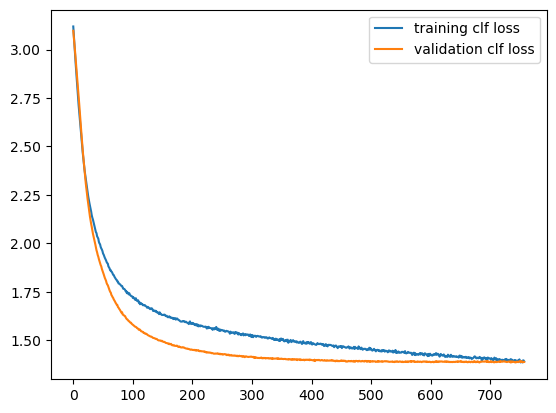

In [25]:

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.enabled = True

model_clf_rnaFull= gae.gae.model_lord.fc_decode_l4(celltype_unique.size,sharedSize,hiddenSize, dropout)
model_clf_rnaFull.cuda()

optimizer_clf_rnaFull = torch.optim.Adam(model_clf_rnaFull.parameters(), lr=lr, weight_decay=weight_decay)

train_loss=[np.inf]*(epochs)
val_loss=[np.inf]*(epochs)


t_ep=time.time()

epCounts=0
for ep in range(epochs):

    train_loss[ep],val_loss[ep]=train(ep,model_clf_rnaFull,optimizer_clf_rnaFull,latent_encoded_rnaShared,trainIdx_all,np.concatenate((valIdx_all,testIdx_all)),celltype_labels=celltype_labels_all)


    if ep>50 and val_loss[ep]>=val_loss[ep-50]:
        epCounts+=1

    if epCounts>100:
        break
        
    if ep%saveFreq == 0 and ep != 0:
        torch.save(model_clf_rnaFull.cpu().state_dict(), os.path.join(modelsavepath,str(sharedSize)+'_'+str(dSpecificSize)+'_'+str(loadEpoch_decoders)+'_'+str(loadEpoch_encoders)+'_ep'+str(ep)+'.pt'))


    model_clf_rnaFull.cuda()
    torch.cuda.empty_cache()
print(' total time: {:.4f}s'.format(time.time() - t_ep))


with open(os.path.join(logsavepath,'train_loss_'+str(sharedSize)+'_'+str(dSpecificSize)+'_'+str(loadEpoch_decoders)+'_'+str(loadEpoch_encoders)), 'wb') as output:
    pickle.dump(train_loss, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath,'val_loss_'+str(sharedSize)+'_'+str(dSpecificSize)+'_'+str(loadEpoch_decoders)+'_'+str(loadEpoch_encoders)), 'wb') as output:
    pickle.dump(val_loss, output, pickle.HIGHEST_PROTOCOL)

plt.plot(np.arange(epochs),train_loss)
plt.plot(np.arange(epochs),val_loss)
# plt.plot(np.arange(epochs),train_loss_kl_ep)
plt.legend(['training clf loss','validation clf loss','training kl loss'],loc='upper right')
plt.savefig(os.path.join(plotsavepath,'loss_seed3_'+str(sharedSize)+'_'+str(dSpecificSize)+'_'+str(loadEpoch_decoders)+'_'+str(loadEpoch_encoders)+'.jpg'))
plt.show()







In [26]:
minlossepoch=np.argmin(val_loss)
minlossepoch_saved=int(np.round(minlossepoch/saveFreq)*saveFreq)
if minlossepoch_saved==0:
    minlossepoch_saved=saveFreq
if val_loss[minlossepoch_saved-saveFreq]<val_loss[minlossepoch_saved]:
    if val_loss[minlossepoch_saved+saveFreq]<val_loss[minlossepoch_saved-saveFreq]:
        minlossepoch_saved=minlossepoch_saved+saveFreq
    else:
        minlossepoch_saved=minlossepoch_saved-saveFreq
if minlossepoch_saved==0:
    minlossepoch_saved=saveFreq
    
testEpoch=minlossepoch_saved

valtestIdx=np.concatenate((valIdx_all,testIdx_all))
model_clf_rnaFull.load_state_dict(torch.load(os.path.join(modelsavepath,str(sharedSize)+'_'+str(dSpecificSize)+'_'+str(loadEpoch_decoders)+'_'+str(loadEpoch_encoders)+'_ep'+str(testEpoch)+'.pt')))
model_clf_rnaFull.cuda()
testLatent=latent_encoded_rnaShared
with torch.no_grad():
    model_clf_rnaFull.eval()
    loss_val_all=0
    correctCount=0
    nvalBatches=int(np.ceil(valtestIdx.shape[0]/batchsize))
    for i in range(nvalBatches):
        testIdx=valtestIdx[i*batchsize:min((i+1)*batchsize,valtestIdx.shape[0])]
        val_labels=torch.tensor(celltype_labels_all[testIdx]).cuda().long()
        valInput=testLatent[testIdx].cuda().float()


        pred = model_clf_rnaFull(valInput)
        predLabels=torch.argmax(pred,dim=1)
        correctCount+=torch.sum(predLabels==val_labels)

        loss=loss_clf(pred, val_labels)
        loss_val_all+=loss.item()

    loss_val_all=loss_val_all/nvalBatches
print(loss_val_all)
print(correctCount/valtestIdx.shape[0])

1.3894089320126701
tensor(0.5293, device='cuda:0')


### classifier with encoded atac shared latent

In [27]:
batchsize=256
saveFreq=50
epochs=1500
lr=0.00001
weight_decay=0
seed=3

dropout=0.1

hiddenSize=128
testSaveName='shareseq_lord_clf'
name='randNoise_sharedRecon_bceWweight_bce_morefilter_sharedLatentATAC_step2'
logsavepath=os.path.join('/data/xinyi/shareseq/results/log',testSaveName,name)
modelsavepath=os.path.join('/data/xinyi/shareseq/results/models',testSaveName,name)
plotsavepath=os.path.join('/data/xinyi/shareseq/results/plots',testSaveName,name)

if not os.path.exists(os.path.join('/data/xinyi/shareseq/results/plots',testSaveName)):
    os.mkdir(os.path.join('/data/xinyi/shareseq/results/plots',testSaveName))
    os.mkdir(os.path.join('/data/xinyi/shareseq/results/models',testSaveName))
    os.mkdir(os.path.join('/data/xinyi/shareseq/results/log',testSaveName))
if not os.path.exists(logsavepath):
    os.mkdir(logsavepath)
if not os.path.exists(modelsavepath):
    os.mkdir(modelsavepath)
if not os.path.exists(plotsavepath):
    os.mkdir(plotsavepath)






 Epoch: 0000 loss_train: 3.1204 loss_val: 3.0980 time: 0.2435s
 Epoch: 0001 loss_train: 3.0706 loss_val: 3.0619 time: 0.2444s
 Epoch: 0002 loss_train: 3.0260 loss_val: 3.0224 time: 0.2501s
 Epoch: 0003 loss_train: 2.9741 loss_val: 2.9861 time: 0.2577s
 Epoch: 0004 loss_train: 2.9285 loss_val: 2.9467 time: 0.2474s
 Epoch: 0005 loss_train: 2.8884 loss_val: 2.9098 time: 0.2498s
 Epoch: 0006 loss_train: 2.8413 loss_val: 2.8704 time: 0.2489s
 Epoch: 0007 loss_train: 2.7964 loss_val: 2.8285 time: 0.2449s
 Epoch: 0008 loss_train: 2.7550 loss_val: 2.7844 time: 0.2497s
 Epoch: 0009 loss_train: 2.7133 loss_val: 2.7445 time: 0.2452s
 Epoch: 0010 loss_train: 2.6776 loss_val: 2.7010 time: 0.2511s
 Epoch: 0011 loss_train: 2.6377 loss_val: 2.6552 time: 0.2474s
 Epoch: 0012 loss_train: 2.5987 loss_val: 2.6123 time: 0.2438s
 Epoch: 0013 loss_train: 2.5632 loss_val: 2.5706 time: 0.2459s
 Epoch: 0014 loss_train: 2.5302 loss_val: 2.5264 time: 0.2476s
 Epoch: 0015 loss_train: 2.4929 loss_val: 2.4882 time: 

 Epoch: 0131 loss_train: 1.6653 loss_val: 1.5496 time: 0.2457s
 Epoch: 0132 loss_train: 1.6665 loss_val: 1.5459 time: 0.2470s
 Epoch: 0133 loss_train: 1.6651 loss_val: 1.5446 time: 0.2509s
 Epoch: 0134 loss_train: 1.6573 loss_val: 1.5426 time: 0.2621s
 Epoch: 0135 loss_train: 1.6564 loss_val: 1.5409 time: 0.2636s
 Epoch: 0136 loss_train: 1.6550 loss_val: 1.5405 time: 0.2490s
 Epoch: 0137 loss_train: 1.6578 loss_val: 1.5399 time: 0.2457s
 Epoch: 0138 loss_train: 1.6511 loss_val: 1.5380 time: 0.2457s
 Epoch: 0139 loss_train: 1.6544 loss_val: 1.5392 time: 0.2585s
 Epoch: 0140 loss_train: 1.6487 loss_val: 1.5393 time: 0.2468s
 Epoch: 0141 loss_train: 1.6474 loss_val: 1.5356 time: 0.2432s
 Epoch: 0142 loss_train: 1.6458 loss_val: 1.5349 time: 0.2441s
 Epoch: 0143 loss_train: 1.6453 loss_val: 1.5330 time: 0.2488s
 Epoch: 0144 loss_train: 1.6388 loss_val: 1.5331 time: 0.2399s
 Epoch: 0145 loss_train: 1.6485 loss_val: 1.5323 time: 0.2367s
 Epoch: 0146 loss_train: 1.6430 loss_val: 1.5303 time: 

 Epoch: 0262 loss_train: 1.5447 loss_val: 1.4732 time: 0.2478s
 Epoch: 0263 loss_train: 1.5386 loss_val: 1.4729 time: 0.2528s
 Epoch: 0264 loss_train: 1.5494 loss_val: 1.4729 time: 0.2490s
 Epoch: 0265 loss_train: 1.5459 loss_val: 1.4740 time: 0.2473s
 Epoch: 0266 loss_train: 1.5411 loss_val: 1.4723 time: 0.2449s
 Epoch: 0267 loss_train: 1.5452 loss_val: 1.4716 time: 0.2494s
 Epoch: 0268 loss_train: 1.5456 loss_val: 1.4705 time: 0.2490s
 Epoch: 0269 loss_train: 1.5440 loss_val: 1.4738 time: 0.2565s
 Epoch: 0270 loss_train: 1.5387 loss_val: 1.4715 time: 0.2555s
 Epoch: 0271 loss_train: 1.5358 loss_val: 1.4731 time: 0.2429s
 Epoch: 0272 loss_train: 1.5466 loss_val: 1.4704 time: 0.2587s
 Epoch: 0273 loss_train: 1.5433 loss_val: 1.4692 time: 0.2538s
 Epoch: 0274 loss_train: 1.5438 loss_val: 1.4716 time: 0.2500s
 Epoch: 0275 loss_train: 1.5399 loss_val: 1.4692 time: 0.2416s
 Epoch: 0276 loss_train: 1.5434 loss_val: 1.4710 time: 0.2474s
 Epoch: 0277 loss_train: 1.5364 loss_val: 1.4681 time: 

 Epoch: 0393 loss_train: 1.4945 loss_val: 1.4609 time: 0.2505s
 Epoch: 0394 loss_train: 1.4900 loss_val: 1.4583 time: 0.2515s
 Epoch: 0395 loss_train: 1.4944 loss_val: 1.4605 time: 0.2558s
 Epoch: 0396 loss_train: 1.4916 loss_val: 1.4602 time: 0.2505s
 Epoch: 0397 loss_train: 1.4874 loss_val: 1.4593 time: 0.2471s
 Epoch: 0398 loss_train: 1.4905 loss_val: 1.4635 time: 0.2529s
 Epoch: 0399 loss_train: 1.4952 loss_val: 1.4642 time: 0.2515s
 Epoch: 0400 loss_train: 1.4849 loss_val: 1.4598 time: 0.2434s
 Epoch: 0401 loss_train: 1.4838 loss_val: 1.4579 time: 0.2402s
 Epoch: 0402 loss_train: 1.4891 loss_val: 1.4587 time: 0.2489s
 Epoch: 0403 loss_train: 1.4891 loss_val: 1.4595 time: 0.2468s
 Epoch: 0404 loss_train: 1.4858 loss_val: 1.4612 time: 0.2495s
 Epoch: 0405 loss_train: 1.4831 loss_val: 1.4600 time: 0.2447s
 Epoch: 0406 loss_train: 1.4834 loss_val: 1.4596 time: 0.2473s
 Epoch: 0407 loss_train: 1.4837 loss_val: 1.4607 time: 0.2476s
 Epoch: 0408 loss_train: 1.4788 loss_val: 1.4590 time: 

 Epoch: 0524 loss_train: 1.4521 loss_val: 1.4643 time: 0.2483s
 Epoch: 0525 loss_train: 1.4507 loss_val: 1.4627 time: 0.2455s
 Epoch: 0526 loss_train: 1.4486 loss_val: 1.4622 time: 0.2472s
 Epoch: 0527 loss_train: 1.4492 loss_val: 1.4582 time: 0.2472s
 Epoch: 0528 loss_train: 1.4431 loss_val: 1.4617 time: 0.2513s
 Epoch: 0529 loss_train: 1.4484 loss_val: 1.4627 time: 0.2394s
 Epoch: 0530 loss_train: 1.4524 loss_val: 1.4617 time: 0.2491s
 Epoch: 0531 loss_train: 1.4490 loss_val: 1.4596 time: 0.2475s
 Epoch: 0532 loss_train: 1.4501 loss_val: 1.4599 time: 0.2470s
 Epoch: 0533 loss_train: 1.4475 loss_val: 1.4595 time: 0.2497s
 Epoch: 0534 loss_train: 1.4453 loss_val: 1.4617 time: 0.2446s
 Epoch: 0535 loss_train: 1.4476 loss_val: 1.4612 time: 0.2488s
 Epoch: 0536 loss_train: 1.4512 loss_val: 1.4616 time: 0.2479s
 Epoch: 0537 loss_train: 1.4448 loss_val: 1.4600 time: 0.2502s
 Epoch: 0538 loss_train: 1.4490 loss_val: 1.4608 time: 0.2463s
 Epoch: 0539 loss_train: 1.4497 loss_val: 1.4613 time: 

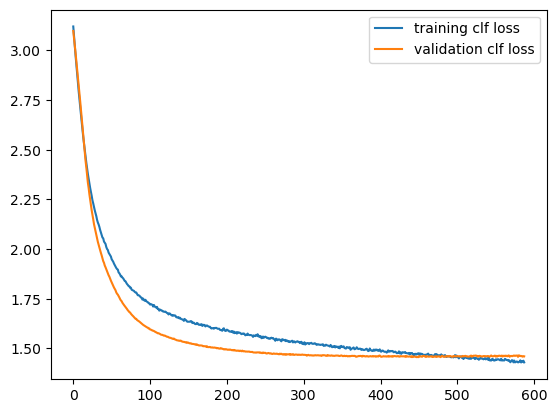

In [28]:

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.enabled = True

model_clf_rnaFull= gae.gae.model_lord.fc_decode_l4(celltype_unique.size,sharedSize,hiddenSize, dropout)
model_clf_rnaFull.cuda()

optimizer_clf_rnaFull = torch.optim.Adam(model_clf_rnaFull.parameters(), lr=lr, weight_decay=weight_decay)

train_loss=[np.inf]*(epochs)
val_loss=[np.inf]*(epochs)


t_ep=time.time()

epCounts=0
for ep in range(epochs):

    train_loss[ep],val_loss[ep]=train(ep,model_clf_rnaFull,optimizer_clf_rnaFull,latent_encoded_atacShared,trainIdx_all,np.concatenate((valIdx_all,testIdx_all)),celltype_labels=celltype_labels_all)

    if ep>50 and val_loss[ep]>=val_loss[ep-50]:
        epCounts+=1

    if epCounts>100:
        break

    if ep%saveFreq == 0 and ep != 0:
        torch.save(model_clf_rnaFull.cpu().state_dict(), os.path.join(modelsavepath,str(sharedSize)+'_'+str(dSpecificSize)+'_'+str(loadEpoch_decoders)+'_'+str(loadEpoch_encoders)+'_ep'+str(ep)+'.pt'))


    model_clf_rnaFull.cuda()
    torch.cuda.empty_cache()
print(' total time: {:.4f}s'.format(time.time() - t_ep))


with open(os.path.join(logsavepath,'train_loss_'+str(sharedSize)+'_'+str(dSpecificSize)+'_'+str(loadEpoch_decoders)+'_'+str(loadEpoch_encoders)), 'wb') as output:
    pickle.dump(train_loss, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath,'val_loss_'+str(sharedSize)+'_'+str(dSpecificSize)+'_'+str(loadEpoch_decoders)+'_'+str(loadEpoch_encoders)), 'wb') as output:
    pickle.dump(val_loss, output, pickle.HIGHEST_PROTOCOL)

plt.plot(np.arange(epochs),train_loss)
plt.plot(np.arange(epochs),val_loss)
# plt.plot(np.arange(epochs),train_loss_kl_ep)
plt.legend(['training clf loss','validation clf loss','training kl loss'],loc='upper right')
plt.savefig(os.path.join(plotsavepath,'loss_seed3_'+str(sharedSize)+'_'+str(dSpecificSize)+'_'+str(loadEpoch_decoders)+'_'+str(loadEpoch_encoders)+'.jpg'))
plt.show()








In [29]:
minlossepoch=np.argmin(val_loss)
minlossepoch_saved=int(np.round(minlossepoch/saveFreq)*saveFreq)
if minlossepoch_saved==0:
    minlossepoch_saved=saveFreq
if val_loss[minlossepoch_saved-saveFreq]<val_loss[minlossepoch_saved]:
    if val_loss[minlossepoch_saved+saveFreq]<val_loss[minlossepoch_saved-saveFreq]:
        minlossepoch_saved=minlossepoch_saved+saveFreq
    else:
        minlossepoch_saved=minlossepoch_saved-saveFreq
if minlossepoch_saved==0:
    minlossepoch_saved=saveFreq
    
testEpoch=minlossepoch_saved
model_clf_rnaFull= gae.gae.model_lord.fc_decode_l4(celltype_unique.size,sharedSize,hiddenSize, dropout)
model_clf_rnaFull.cuda()
valtestIdx=np.concatenate((valIdx_all,testIdx_all))
model_clf_rnaFull.load_state_dict(torch.load(os.path.join(modelsavepath,str(sharedSize)+'_'+str(dSpecificSize)+'_'+str(loadEpoch_decoders)+'_'+str(loadEpoch_encoders)+'_ep'+str(testEpoch)+'.pt')))
model_clf_rnaFull.cuda()
testLatent=latent_encoded_atacShared
with torch.no_grad():
    model_clf_rnaFull.eval()
    loss_val_all=0
    correctCount=0
    nvalBatches=int(np.ceil(valtestIdx.shape[0]/batchsize))
    for i in range(nvalBatches):
        testIdx=valtestIdx[i*batchsize:min((i+1)*batchsize,valtestIdx.shape[0])]
        val_labels=torch.tensor(celltype_labels_all[testIdx]).cuda().long()
        valInput=testLatent[testIdx].cuda().float()


        pred = model_clf_rnaFull(valInput)
        predLabels=torch.argmax(pred,dim=1)
        correctCount+=torch.sum(predLabels==val_labels)

        loss=loss_clf(pred, val_labels)
        loss_val_all+=loss.item()

    loss_val_all=loss_val_all/nvalBatches
print(loss_val_all)
print(correctCount/valtestIdx.shape[0])

1.4598086511387545
tensor(0.5058, device='cuda:0')


### classifier with encoded atac full latent

In [30]:
batchsize=256
saveFreq=50
epochs=1500
lr=0.00001
weight_decay=0
seed=3

dropout=0.1

hiddenSize=128
testSaveName='shareseq_lord_clf'
name='randNoise_sharedRecon_bceWweight_bce_morefilter_fullLatentATAC_step2'
logsavepath=os.path.join('/data/xinyi/shareseq/results/log',testSaveName,name)
modelsavepath=os.path.join('/data/xinyi/shareseq/results/models',testSaveName,name)
plotsavepath=os.path.join('/data/xinyi/shareseq/results/plots',testSaveName,name)

if not os.path.exists(os.path.join('/data/xinyi/shareseq/results/plots',testSaveName)):
    os.mkdir(os.path.join('/data/xinyi/shareseq/results/plots',testSaveName))
    os.mkdir(os.path.join('/data/xinyi/shareseq/results/models',testSaveName))
    os.mkdir(os.path.join('/data/xinyi/shareseq/results/log',testSaveName))
if not os.path.exists(logsavepath):
    os.mkdir(logsavepath)
if not os.path.exists(modelsavepath):
    os.mkdir(modelsavepath)
if not os.path.exists(plotsavepath):
    os.mkdir(plotsavepath)







 Epoch: 0000 loss_train: 3.2486 loss_val: 3.1499 time: 0.2423s
 Epoch: 0001 loss_train: 3.1946 loss_val: 3.1150 time: 0.2459s
 Epoch: 0002 loss_train: 3.1444 loss_val: 3.0798 time: 0.2468s
 Epoch: 0003 loss_train: 3.0980 loss_val: 3.0473 time: 0.2520s
 Epoch: 0004 loss_train: 3.0495 loss_val: 3.0109 time: 0.2469s
 Epoch: 0005 loss_train: 3.0044 loss_val: 2.9768 time: 0.2506s
 Epoch: 0006 loss_train: 2.9606 loss_val: 2.9402 time: 0.2507s
 Epoch: 0007 loss_train: 2.9148 loss_val: 2.9005 time: 0.2491s
 Epoch: 0008 loss_train: 2.8730 loss_val: 2.8661 time: 0.2508s
 Epoch: 0009 loss_train: 2.8277 loss_val: 2.8277 time: 0.2538s
 Epoch: 0010 loss_train: 2.7896 loss_val: 2.7906 time: 0.2573s
 Epoch: 0011 loss_train: 2.7462 loss_val: 2.7424 time: 0.2539s
 Epoch: 0012 loss_train: 2.7056 loss_val: 2.7036 time: 0.2472s
 Epoch: 0013 loss_train: 2.6686 loss_val: 2.6639 time: 0.2531s
 Epoch: 0014 loss_train: 2.6285 loss_val: 2.6235 time: 0.2586s
 Epoch: 0015 loss_train: 2.5899 loss_val: 2.5782 time: 

 Epoch: 0131 loss_train: 1.6519 loss_val: 1.5319 time: 0.2564s
 Epoch: 0132 loss_train: 1.6518 loss_val: 1.5314 time: 0.2592s
 Epoch: 0133 loss_train: 1.6522 loss_val: 1.5299 time: 0.2619s
 Epoch: 0134 loss_train: 1.6482 loss_val: 1.5274 time: 0.2456s
 Epoch: 0135 loss_train: 1.6529 loss_val: 1.5270 time: 0.2494s
 Epoch: 0136 loss_train: 1.6500 loss_val: 1.5264 time: 0.2501s
 Epoch: 0137 loss_train: 1.6408 loss_val: 1.5230 time: 0.2469s
 Epoch: 0138 loss_train: 1.6418 loss_val: 1.5226 time: 0.2610s
 Epoch: 0139 loss_train: 1.6406 loss_val: 1.5200 time: 0.2460s
 Epoch: 0140 loss_train: 1.6365 loss_val: 1.5209 time: 0.2479s
 Epoch: 0141 loss_train: 1.6373 loss_val: 1.5184 time: 0.2507s
 Epoch: 0142 loss_train: 1.6374 loss_val: 1.5174 time: 0.2525s
 Epoch: 0143 loss_train: 1.6363 loss_val: 1.5159 time: 0.2479s
 Epoch: 0144 loss_train: 1.6342 loss_val: 1.5178 time: 0.2493s
 Epoch: 0145 loss_train: 1.6310 loss_val: 1.5152 time: 0.2506s
 Epoch: 0146 loss_train: 1.6210 loss_val: 1.5144 time: 

 Epoch: 0262 loss_train: 1.5273 loss_val: 1.4469 time: 0.2494s
 Epoch: 0263 loss_train: 1.5306 loss_val: 1.4471 time: 0.2480s
 Epoch: 0264 loss_train: 1.5313 loss_val: 1.4454 time: 0.2497s
 Epoch: 0265 loss_train: 1.5239 loss_val: 1.4454 time: 0.2431s
 Epoch: 0266 loss_train: 1.5280 loss_val: 1.4460 time: 0.2472s
 Epoch: 0267 loss_train: 1.5229 loss_val: 1.4468 time: 0.2432s
 Epoch: 0268 loss_train: 1.5246 loss_val: 1.4444 time: 0.2507s
 Epoch: 0269 loss_train: 1.5274 loss_val: 1.4456 time: 0.2449s
 Epoch: 0270 loss_train: 1.5154 loss_val: 1.4430 time: 0.2481s
 Epoch: 0271 loss_train: 1.5209 loss_val: 1.4473 time: 0.2486s
 Epoch: 0272 loss_train: 1.5185 loss_val: 1.4466 time: 0.2594s
 Epoch: 0273 loss_train: 1.5239 loss_val: 1.4450 time: 0.2504s
 Epoch: 0274 loss_train: 1.5205 loss_val: 1.4451 time: 0.2415s
 Epoch: 0275 loss_train: 1.5204 loss_val: 1.4413 time: 0.2488s
 Epoch: 0276 loss_train: 1.5169 loss_val: 1.4423 time: 0.2479s
 Epoch: 0277 loss_train: 1.5163 loss_val: 1.4417 time: 

 Epoch: 0393 loss_train: 1.4722 loss_val: 1.4233 time: 0.2513s
 Epoch: 0394 loss_train: 1.4676 loss_val: 1.4272 time: 0.2527s
 Epoch: 0395 loss_train: 1.4676 loss_val: 1.4253 time: 0.2514s
 Epoch: 0396 loss_train: 1.4672 loss_val: 1.4254 time: 0.2574s
 Epoch: 0397 loss_train: 1.4640 loss_val: 1.4267 time: 0.2547s
 Epoch: 0398 loss_train: 1.4603 loss_val: 1.4220 time: 0.2553s
 Epoch: 0399 loss_train: 1.4641 loss_val: 1.4248 time: 0.2510s
 Epoch: 0400 loss_train: 1.4662 loss_val: 1.4229 time: 0.2501s
 Epoch: 0401 loss_train: 1.4704 loss_val: 1.4235 time: 0.2480s
 Epoch: 0402 loss_train: 1.4565 loss_val: 1.4275 time: 0.2500s
 Epoch: 0403 loss_train: 1.4651 loss_val: 1.4243 time: 0.2451s
 Epoch: 0404 loss_train: 1.4657 loss_val: 1.4261 time: 0.2453s
 Epoch: 0405 loss_train: 1.4686 loss_val: 1.4240 time: 0.2491s
 Epoch: 0406 loss_train: 1.4637 loss_val: 1.4230 time: 0.2444s
 Epoch: 0407 loss_train: 1.4577 loss_val: 1.4251 time: 0.2469s
 Epoch: 0408 loss_train: 1.4626 loss_val: 1.4222 time: 

 Epoch: 0524 loss_train: 1.4162 loss_val: 1.4212 time: 0.2476s
 Epoch: 0525 loss_train: 1.4211 loss_val: 1.4203 time: 0.2496s
 Epoch: 0526 loss_train: 1.4240 loss_val: 1.4201 time: 0.2509s
 Epoch: 0527 loss_train: 1.4244 loss_val: 1.4201 time: 0.2446s
 Epoch: 0528 loss_train: 1.4248 loss_val: 1.4220 time: 0.2472s
 Epoch: 0529 loss_train: 1.4185 loss_val: 1.4178 time: 0.2491s
 Epoch: 0530 loss_train: 1.4246 loss_val: 1.4218 time: 0.2510s
 Epoch: 0531 loss_train: 1.4185 loss_val: 1.4180 time: 0.2475s
 Epoch: 0532 loss_train: 1.4159 loss_val: 1.4209 time: 0.2467s
 Epoch: 0533 loss_train: 1.4194 loss_val: 1.4180 time: 0.2460s
 Epoch: 0534 loss_train: 1.4189 loss_val: 1.4201 time: 0.2451s
 Epoch: 0535 loss_train: 1.4201 loss_val: 1.4213 time: 0.2528s
 Epoch: 0536 loss_train: 1.4147 loss_val: 1.4194 time: 0.2509s
 Epoch: 0537 loss_train: 1.4179 loss_val: 1.4199 time: 0.2476s
 Epoch: 0538 loss_train: 1.4210 loss_val: 1.4180 time: 0.2511s
 Epoch: 0539 loss_train: 1.4180 loss_val: 1.4186 time: 

 Epoch: 0655 loss_train: 1.3861 loss_val: 1.4171 time: 0.2498s
 Epoch: 0656 loss_train: 1.3876 loss_val: 1.4188 time: 0.2510s
 Epoch: 0657 loss_train: 1.3796 loss_val: 1.4167 time: 0.2497s
 Epoch: 0658 loss_train: 1.3882 loss_val: 1.4210 time: 0.2457s
 Epoch: 0659 loss_train: 1.3884 loss_val: 1.4191 time: 0.2498s
 Epoch: 0660 loss_train: 1.3829 loss_val: 1.4162 time: 0.2471s
 Epoch: 0661 loss_train: 1.3862 loss_val: 1.4199 time: 0.2446s
 Epoch: 0662 loss_train: 1.3861 loss_val: 1.4183 time: 0.2443s
 Epoch: 0663 loss_train: 1.3857 loss_val: 1.4200 time: 0.2471s
 Epoch: 0664 loss_train: 1.3878 loss_val: 1.4190 time: 0.2458s
 Epoch: 0665 loss_train: 1.3824 loss_val: 1.4164 time: 0.2547s
 Epoch: 0666 loss_train: 1.3873 loss_val: 1.4181 time: 0.2552s
 Epoch: 0667 loss_train: 1.3890 loss_val: 1.4160 time: 0.2608s
 Epoch: 0668 loss_train: 1.3854 loss_val: 1.4176 time: 0.2478s
 Epoch: 0669 loss_train: 1.3885 loss_val: 1.4191 time: 0.2510s
 Epoch: 0670 loss_train: 1.3807 loss_val: 1.4152 time: 

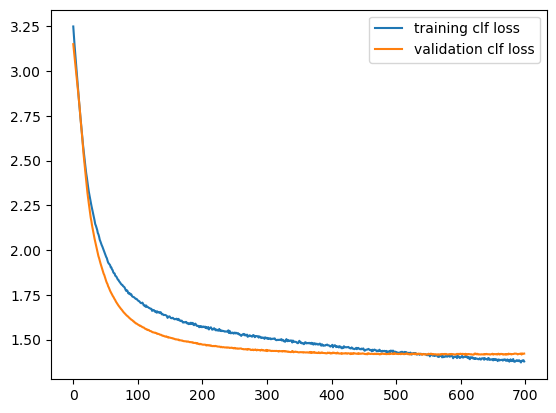

In [31]:

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.enabled = True

model_clf_rnaFull= gae.gae.model_lord.fc_decode_l4(celltype_unique.size,sharedSize+dSpecificSize,hiddenSize, dropout)
model_clf_rnaFull.cuda()

optimizer_clf_rnaFull = torch.optim.Adam(model_clf_rnaFull.parameters(), lr=lr, weight_decay=weight_decay)

train_loss=[np.inf]*(epochs)
val_loss=[np.inf]*(epochs)


t_ep=time.time()
epCounts=0
for ep in range(epochs):

    train_loss[ep],val_loss[ep]=train(ep,model_clf_rnaFull,optimizer_clf_rnaFull,torch.cat((latent_encoded_atacShared,latent_encoded_atacD),dim=1),trainIdx_all,np.concatenate((valIdx_all,testIdx_all)),celltype_labels=celltype_labels_all)

    if ep>50 and val_loss[ep]>=val_loss[ep-50]:
        epCounts+=1

    if epCounts>100:
        break

    if ep%saveFreq == 0 and ep != 0:
        torch.save(model_clf_rnaFull.cpu().state_dict(), os.path.join(modelsavepath,str(sharedSize)+'_'+str(dSpecificSize)+'_'+str(loadEpoch_decoders)+'_'+str(loadEpoch_encoders)+'_ep'+str(ep)+'.pt'))


    model_clf_rnaFull.cuda()
    torch.cuda.empty_cache()
print(' total time: {:.4f}s'.format(time.time() - t_ep))


with open(os.path.join(logsavepath,'train_loss_'+str(sharedSize)+'_'+str(dSpecificSize)+'_'+str(loadEpoch_decoders)+'_'+str(loadEpoch_encoders)), 'wb') as output:
    pickle.dump(train_loss, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath,'val_loss_'+str(sharedSize)+'_'+str(dSpecificSize)+'_'+str(loadEpoch_decoders)+'_'+str(loadEpoch_encoders)), 'wb') as output:
    pickle.dump(val_loss, output, pickle.HIGHEST_PROTOCOL)

plt.plot(np.arange(epochs),train_loss)
plt.plot(np.arange(epochs),val_loss)
# plt.plot(np.arange(epochs),train_loss_kl_ep)
plt.legend(['training clf loss','validation clf loss','training kl loss'],loc='upper right')
plt.savefig(os.path.join(plotsavepath,'loss_seed3_'+str(sharedSize)+'_'+str(dSpecificSize)+'_'+str(loadEpoch_decoders)+'_'+str(loadEpoch_encoders)+'.jpg'))
plt.show()









In [32]:
minlossepoch=np.argmin(val_loss)
minlossepoch_saved=int(np.round(minlossepoch/saveFreq)*saveFreq)
if minlossepoch_saved==0:
    minlossepoch_saved=saveFreq
if val_loss[minlossepoch_saved-saveFreq]<val_loss[minlossepoch_saved]:
    if val_loss[minlossepoch_saved+saveFreq]<val_loss[minlossepoch_saved-saveFreq]:
        minlossepoch_saved=minlossepoch_saved+saveFreq
    else:
        minlossepoch_saved=minlossepoch_saved-saveFreq
if minlossepoch_saved==0:
    minlossepoch_saved=saveFreq
    
testEpoch=minlossepoch_saved
model_clf_rnaFull= gae.gae.model_lord.fc_decode_l4(celltype_unique.size,sharedSize+dSpecificSize,hiddenSize, dropout)
model_clf_rnaFull.cuda()
valtestIdx=np.concatenate((valIdx_all,testIdx_all))
model_clf_rnaFull.load_state_dict(torch.load(os.path.join(modelsavepath,str(sharedSize)+'_'+str(dSpecificSize)+'_'+str(loadEpoch_decoders)+'_'+str(loadEpoch_encoders)+'_ep'+str(testEpoch)+'.pt')))
model_clf_rnaFull.cuda()
testLatent=torch.cat((latent_encoded_atacShared,latent_encoded_atacD),dim=1)
with torch.no_grad():
    model_clf_rnaFull.eval()
    loss_val_all=0
    correctCount=0
    nvalBatches=int(np.ceil(valtestIdx.shape[0]/batchsize))
    for i in range(nvalBatches):
        testIdx=valtestIdx[i*batchsize:min((i+1)*batchsize,valtestIdx.shape[0])]
        val_labels=torch.tensor(celltype_labels_all[testIdx]).cuda().long()
        valInput=testLatent[testIdx].cuda().float()


        pred = model_clf_rnaFull(valInput)
        predLabels=torch.argmax(pred,dim=1)
        correctCount+=torch.sum(predLabels==val_labels)

        loss=loss_clf(pred, val_labels)
        loss_val_all+=loss.item()

    loss_val_all=loss_val_all/nvalBatches
print(loss_val_all)
print(correctCount/valtestIdx.shape[0])

1.419610205818625
tensor(0.5158, device='cuda:0')


### classifier with encoded rna full latent

In [33]:
batchsize=256
saveFreq=50
epochs=1500
lr=0.00001
weight_decay=0
seed=3

dropout=0.1

hiddenSize=128
testSaveName='shareseq_lord_clf'
name='randNoise_sharedRecon_bceWweight_bce_morefilter_fullLatentRNA_step2'
logsavepath=os.path.join('/data/xinyi/shareseq/results/log',testSaveName,name)
modelsavepath=os.path.join('/data/xinyi/shareseq/results/models',testSaveName,name)
plotsavepath=os.path.join('/data/xinyi/shareseq/results/plots',testSaveName,name)

if not os.path.exists(os.path.join('/data/xinyi/shareseq/results/plots',testSaveName)):
    os.mkdir(os.path.join('/data/xinyi/shareseq/results/plots',testSaveName))
    os.mkdir(os.path.join('/data/xinyi/shareseq/results/models',testSaveName))
    os.mkdir(os.path.join('/data/xinyi/shareseq/results/log',testSaveName))
if not os.path.exists(logsavepath):
    os.mkdir(logsavepath)
if not os.path.exists(modelsavepath):
    os.mkdir(modelsavepath)
if not os.path.exists(plotsavepath):
    os.mkdir(plotsavepath)








 Epoch: 0000 loss_train: 3.2450 loss_val: 3.1510 time: 0.2437s
 Epoch: 0001 loss_train: 3.1897 loss_val: 3.1160 time: 0.2425s
 Epoch: 0002 loss_train: 3.1395 loss_val: 3.0792 time: 0.2478s
 Epoch: 0003 loss_train: 3.0902 loss_val: 3.0450 time: 0.2441s
 Epoch: 0004 loss_train: 3.0388 loss_val: 3.0068 time: 0.2460s
 Epoch: 0005 loss_train: 2.9917 loss_val: 2.9727 time: 0.2429s
 Epoch: 0006 loss_train: 2.9439 loss_val: 2.9334 time: 0.2498s
 Epoch: 0007 loss_train: 2.8945 loss_val: 2.8930 time: 0.2493s
 Epoch: 0008 loss_train: 2.8499 loss_val: 2.8554 time: 0.2491s
 Epoch: 0009 loss_train: 2.8012 loss_val: 2.8169 time: 0.2527s
 Epoch: 0010 loss_train: 2.7626 loss_val: 2.7774 time: 0.2451s
 Epoch: 0011 loss_train: 2.7182 loss_val: 2.7317 time: 0.2464s
 Epoch: 0012 loss_train: 2.6747 loss_val: 2.6887 time: 0.2457s
 Epoch: 0013 loss_train: 2.6361 loss_val: 2.6528 time: 0.2451s
 Epoch: 0014 loss_train: 2.5947 loss_val: 2.6099 time: 0.2430s
 Epoch: 0015 loss_train: 2.5544 loss_val: 2.5676 time: 

 Epoch: 0131 loss_train: 1.5250 loss_val: 1.3684 time: 0.2445s
 Epoch: 0132 loss_train: 1.5281 loss_val: 1.3631 time: 0.2414s
 Epoch: 0133 loss_train: 1.5230 loss_val: 1.3629 time: 0.2467s
 Epoch: 0134 loss_train: 1.5198 loss_val: 1.3633 time: 0.2441s
 Epoch: 0135 loss_train: 1.5212 loss_val: 1.3585 time: 0.2518s
 Epoch: 0136 loss_train: 1.5191 loss_val: 1.3566 time: 0.2484s
 Epoch: 0137 loss_train: 1.5106 loss_val: 1.3574 time: 0.2480s
 Epoch: 0138 loss_train: 1.5145 loss_val: 1.3534 time: 0.2511s
 Epoch: 0139 loss_train: 1.5119 loss_val: 1.3513 time: 0.2476s
 Epoch: 0140 loss_train: 1.5075 loss_val: 1.3487 time: 0.2516s
 Epoch: 0141 loss_train: 1.5047 loss_val: 1.3461 time: 0.2520s
 Epoch: 0142 loss_train: 1.5026 loss_val: 1.3449 time: 0.2439s
 Epoch: 0143 loss_train: 1.4989 loss_val: 1.3427 time: 0.2453s
 Epoch: 0144 loss_train: 1.5019 loss_val: 1.3402 time: 0.2521s
 Epoch: 0145 loss_train: 1.4908 loss_val: 1.3388 time: 0.2436s
 Epoch: 0146 loss_train: 1.4847 loss_val: 1.3358 time: 

 Epoch: 0262 loss_train: 1.3699 loss_val: 1.2258 time: 0.2486s
 Epoch: 0263 loss_train: 1.3727 loss_val: 1.2236 time: 0.2586s
 Epoch: 0264 loss_train: 1.3724 loss_val: 1.2270 time: 0.2427s
 Epoch: 0265 loss_train: 1.3700 loss_val: 1.2254 time: 0.2463s
 Epoch: 0266 loss_train: 1.3701 loss_val: 1.2238 time: 0.2503s
 Epoch: 0267 loss_train: 1.3673 loss_val: 1.2218 time: 0.2431s
 Epoch: 0268 loss_train: 1.3671 loss_val: 1.2219 time: 0.2489s
 Epoch: 0269 loss_train: 1.3668 loss_val: 1.2242 time: 0.2444s
 Epoch: 0270 loss_train: 1.3587 loss_val: 1.2231 time: 0.2471s
 Epoch: 0271 loss_train: 1.3601 loss_val: 1.2209 time: 0.2518s
 Epoch: 0272 loss_train: 1.3571 loss_val: 1.2192 time: 0.2405s
 Epoch: 0273 loss_train: 1.3562 loss_val: 1.2197 time: 0.2443s
 Epoch: 0274 loss_train: 1.3613 loss_val: 1.2183 time: 0.2467s
 Epoch: 0275 loss_train: 1.3630 loss_val: 1.2214 time: 0.2534s
 Epoch: 0276 loss_train: 1.3605 loss_val: 1.2202 time: 0.2433s
 Epoch: 0277 loss_train: 1.3603 loss_val: 1.2181 time: 

 Epoch: 0393 loss_train: 1.3002 loss_val: 1.1914 time: 0.2472s
 Epoch: 0394 loss_train: 1.2974 loss_val: 1.1896 time: 0.2504s
 Epoch: 0395 loss_train: 1.3023 loss_val: 1.1907 time: 0.2474s
 Epoch: 0396 loss_train: 1.2992 loss_val: 1.1905 time: 0.2503s
 Epoch: 0397 loss_train: 1.2937 loss_val: 1.1894 time: 0.2507s
 Epoch: 0398 loss_train: 1.2958 loss_val: 1.1908 time: 0.2425s
 Epoch: 0399 loss_train: 1.2958 loss_val: 1.1905 time: 0.2525s
 Epoch: 0400 loss_train: 1.3055 loss_val: 1.1899 time: 0.2441s
 Epoch: 0401 loss_train: 1.2954 loss_val: 1.1887 time: 0.2617s
 Epoch: 0402 loss_train: 1.2919 loss_val: 1.1896 time: 0.2502s
 Epoch: 0403 loss_train: 1.2941 loss_val: 1.1877 time: 0.2454s
 Epoch: 0404 loss_train: 1.2965 loss_val: 1.1893 time: 0.2549s
 Epoch: 0405 loss_train: 1.2983 loss_val: 1.1894 time: 0.2461s
 Epoch: 0406 loss_train: 1.2941 loss_val: 1.1907 time: 0.2480s
 Epoch: 0407 loss_train: 1.2917 loss_val: 1.1876 time: 0.2477s
 Epoch: 0408 loss_train: 1.2940 loss_val: 1.1899 time: 

 Epoch: 0524 loss_train: 1.2449 loss_val: 1.1798 time: 0.2571s
 Epoch: 0525 loss_train: 1.2487 loss_val: 1.1829 time: 0.2557s
 Epoch: 0526 loss_train: 1.2477 loss_val: 1.1818 time: 0.2482s
 Epoch: 0527 loss_train: 1.2481 loss_val: 1.1826 time: 0.2398s
 Epoch: 0528 loss_train: 1.2465 loss_val: 1.1810 time: 0.2627s
 Epoch: 0529 loss_train: 1.2483 loss_val: 1.1809 time: 0.2542s
 Epoch: 0530 loss_train: 1.2486 loss_val: 1.1802 time: 0.2529s
 Epoch: 0531 loss_train: 1.2517 loss_val: 1.1835 time: 0.2482s
 Epoch: 0532 loss_train: 1.2445 loss_val: 1.1794 time: 0.2466s
 Epoch: 0533 loss_train: 1.2450 loss_val: 1.1825 time: 0.2480s
 Epoch: 0534 loss_train: 1.2461 loss_val: 1.1793 time: 0.2463s
 Epoch: 0535 loss_train: 1.2470 loss_val: 1.1820 time: 0.2504s
 Epoch: 0536 loss_train: 1.2490 loss_val: 1.1824 time: 0.2402s
 Epoch: 0537 loss_train: 1.2482 loss_val: 1.1805 time: 0.2493s
 Epoch: 0538 loss_train: 1.2490 loss_val: 1.1811 time: 0.2482s
 Epoch: 0539 loss_train: 1.2449 loss_val: 1.1796 time: 

 Epoch: 0655 loss_train: 1.2088 loss_val: 1.1814 time: 0.2507s
 Epoch: 0656 loss_train: 1.2087 loss_val: 1.1807 time: 0.2546s
 Epoch: 0657 loss_train: 1.2018 loss_val: 1.1824 time: 0.2492s
 Epoch: 0658 loss_train: 1.2072 loss_val: 1.1795 time: 0.2486s
 Epoch: 0659 loss_train: 1.2094 loss_val: 1.1823 time: 0.2499s
 Epoch: 0660 loss_train: 1.2144 loss_val: 1.1809 time: 0.2541s
 Epoch: 0661 loss_train: 1.2162 loss_val: 1.1827 time: 0.2633s
 Epoch: 0662 loss_train: 1.2111 loss_val: 1.1809 time: 0.2447s
 Epoch: 0663 loss_train: 1.2117 loss_val: 1.1811 time: 0.2493s
 Epoch: 0664 loss_train: 1.2084 loss_val: 1.1845 time: 0.2497s
 Epoch: 0665 loss_train: 1.2073 loss_val: 1.1801 time: 0.2471s
 Epoch: 0666 loss_train: 1.2130 loss_val: 1.1800 time: 0.2603s
 Epoch: 0667 loss_train: 1.2102 loss_val: 1.1827 time: 0.2514s
 Epoch: 0668 loss_train: 1.2159 loss_val: 1.1800 time: 0.2468s
 Epoch: 0669 loss_train: 1.2041 loss_val: 1.1805 time: 0.2546s
 Epoch: 0670 loss_train: 1.2071 loss_val: 1.1814 time: 

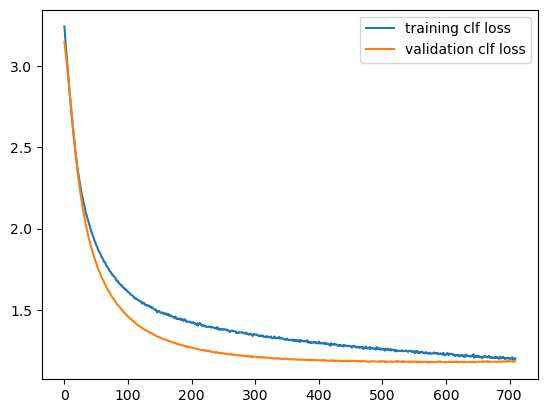

In [34]:

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.enabled = True

model_clf_rnaFull= gae.gae.model_lord.fc_decode_l4(celltype_unique.size,sharedSize+dSpecificSize,hiddenSize, dropout)
model_clf_rnaFull.cuda()

optimizer_clf_rnaFull = torch.optim.Adam(model_clf_rnaFull.parameters(), lr=lr, weight_decay=weight_decay)

train_loss=[np.inf]*(epochs)
val_loss=[np.inf]*(epochs)


t_ep=time.time()
epCounts=0
for ep in range(epochs):

    train_loss[ep],val_loss[ep]=train(ep,model_clf_rnaFull,optimizer_clf_rnaFull,torch.cat((latent_encoded_rnaShared,latent_encoded_rnaD),dim=1),trainIdx_all,np.concatenate((valIdx_all,testIdx_all)),celltype_labels=celltype_labels_all)

    if ep>50 and val_loss[ep]>=val_loss[ep-50]:
        epCounts+=1

    if epCounts>100:
        break

    if ep%saveFreq == 0 and ep != 0:
        torch.save(model_clf_rnaFull.cpu().state_dict(), os.path.join(modelsavepath,str(sharedSize)+'_'+str(dSpecificSize)+'_'+str(loadEpoch_decoders)+'_'+str(loadEpoch_encoders)+'_ep'+str(ep)+'.pt'))


    model_clf_rnaFull.cuda()
    torch.cuda.empty_cache()
print(' total time: {:.4f}s'.format(time.time() - t_ep))


with open(os.path.join(logsavepath,'train_loss_'+str(sharedSize)+'_'+str(dSpecificSize)+'_'+str(loadEpoch_decoders)+'_'+str(loadEpoch_encoders)), 'wb') as output:
    pickle.dump(train_loss, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath,'val_loss_'+str(sharedSize)+'_'+str(dSpecificSize)+'_'+str(loadEpoch_decoders)+'_'+str(loadEpoch_encoders)), 'wb') as output:
    pickle.dump(val_loss, output, pickle.HIGHEST_PROTOCOL)

plt.plot(np.arange(epochs),train_loss)
plt.plot(np.arange(epochs),val_loss)
# plt.plot(np.arange(epochs),train_loss_kl_ep)
plt.legend(['training clf loss','validation clf loss','training kl loss'],loc='upper right')
plt.savefig(os.path.join(plotsavepath,'loss_seed3_'+str(sharedSize)+'_'+str(dSpecificSize)+'_'+str(loadEpoch_decoders)+'_'+str(loadEpoch_encoders)+'.jpg'))
plt.show()










In [35]:
minlossepoch=np.argmin(val_loss)
minlossepoch_saved=int(np.round(minlossepoch/saveFreq)*saveFreq)
if minlossepoch_saved==0:
    minlossepoch_saved=saveFreq
if val_loss[minlossepoch_saved-saveFreq]<val_loss[minlossepoch_saved]:
    if val_loss[minlossepoch_saved+saveFreq]<val_loss[minlossepoch_saved-saveFreq]:
        minlossepoch_saved=minlossepoch_saved+saveFreq
    else:
        minlossepoch_saved=minlossepoch_saved-saveFreq
if minlossepoch_saved==0:
    minlossepoch_saved=saveFreq
    
testEpoch=minlossepoch_saved
valtestIdx=np.concatenate((valIdx_all,testIdx_all))
model_clf_rnaFull.load_state_dict(torch.load(os.path.join(modelsavepath,str(sharedSize)+'_'+str(dSpecificSize)+'_'+str(loadEpoch_decoders)+'_'+str(loadEpoch_encoders)+'_ep'+str(testEpoch)+'.pt')))
model_clf_rnaFull.cuda()
testLatent=torch.cat((latent_encoded_rnaShared,latent_encoded_rnaD),dim=1)
with torch.no_grad():
    model_clf_rnaFull.eval()
    loss_val_all=0
    correctCount=0
    nvalBatches=int(np.ceil(valtestIdx.shape[0]/batchsize))
    for i in range(nvalBatches):
        testIdx=valtestIdx[i*batchsize:min((i+1)*batchsize,valtestIdx.shape[0])]
        val_labels=torch.tensor(celltype_labels_all[testIdx]).cuda().long()
        valInput=testLatent[testIdx].cuda().float()


        pred = model_clf_rnaFull(valInput)
        predLabels=torch.argmax(pred,dim=1)
        correctCount+=torch.sum(predLabels==val_labels)

        loss=loss_clf(pred, val_labels)
        loss_val_all+=loss.item()

    loss_val_all=loss_val_all/nvalBatches
print(loss_val_all)
print(correctCount/valtestIdx.shape[0])

1.1771526406793034
tensor(0.6046, device='cuda:0')
